# Processing OM10 systems with a null-deblender

In this notebook, we will discuss how we could process OM10 lensed systems with a null-deblender. 

## Requirements

OM10 and SLRealizer are the only requirements.

In [17]:
import om10
import desc.slrealizer
import warnings
warnings.filterwarnings("ignore")

After importing the packages, we have to load the OM10 catalog. We will query the systems that satisfy the criteria : `maglim=23.3,area=18000.0,IQ=0.75`.

In [18]:
db = om10.DB()
db.select_random(maglim=23.3,area=18000.0,IQ=0.75)
db.paint(synthetic=True)
realizer = desc.slrealizer.SLRealizer(catalog=db, observation="../../../data/twinkles_observation_history.csv")

OM10: Full db.lenses table contains 15658 systems
OM10: Initial db.sample contains 15658 systems
OM10: selection yields 2813 lenses


Here we are enabling the inline options for matplotlib and pylab so that we can see the plot in the jupyter notebook.

In [19]:
%matplotlib inline
%pylab inline
matplotlib.use('TkAgg')
matplotlib.rc('text', usetex=False)

Populating the interactive namespace from numpy and matplotlib


This process is not strictly necessary, but here we are choosing a good lens system, with large image separations and full four images.

In [20]:
wide = db.sample[np.where(db.sample['IMSEP'] > 1.0)]
print "Number of lenses with image separation > 1.0 arcsec = ",len(wide)

wide_quads = wide[np.where(wide['NIMG'] == 4)]
print "Number of these with 4 images = ",len(wide_quads)

bright_wide_quads = wide[np.where(wide_quads['MAGI'] < 22)]
print "Number of these with i3 < 22 = ",len(bright_wide_quads)

db.sample = bright_wide_quads    
                      
k = db.sample[0]['LENSID']

Number of lenses with image separation > 1.0 arcsec =  1954
Number of these with 4 images =  290
Number of these with i3 < 22 =  127


Then, we call the method `deblend` in the SLRealizer package. We need to specify the lensID and whether we want to null_deblend the objects. This method uses `skimage.measure.moments` method and plots both the original array and null-deblended array.

OM10: Extracted OM10 lens number 5730007:
 LENSID FLAGTYPE NIMG ZLENS ... i_SDSS_quasar z_SDSS_quasar u_SDSS_quasar
------- -------- ---- ----- ... ------------- ------------- -------------
5730007        0    2  0.51 ...         19.47 19.4540158834 19.9832402129
##################### PLOTTING ALL SOURCES ##################################


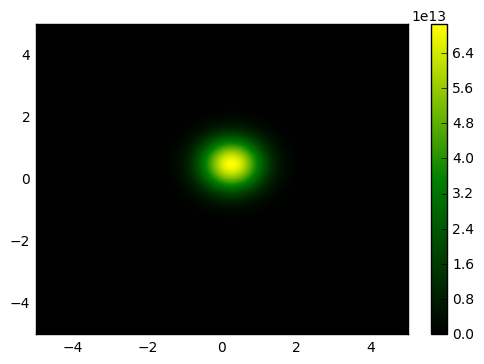

##################### AFTER NULL DEBLENDING ##################################


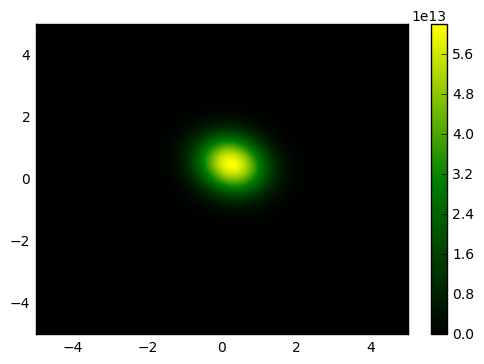

In [21]:
realizer.deblend(lensID=k, null_deblend=True)